# This notebook is used for IBM Data Science Capstone Project

Import libraries

In [1]:
import pandas as pd;
import numpy as np;
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install geocoder
import geocoder
from bs4 import BeautifulSoup

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

! pip install folium==0.5.0
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 102kB 7.5MB/s ta 0:00:011
     |████████████████████████████████| 81kB 6.7MB/s eta 0:00:011
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
Libraries imported.


# 1. Download data

Download neighbourhood data

In [2]:
data = requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Ottawa').text

soup = BeautifulSoup(data, 'html.parser')

neighbourhood = []

for row in soup.find_all("div", class_="div-col"):
    for item in row.select("a"):
        if item.has_attr('title'):
            neighbourhood.append(item.text)

ne = pd.DataFrame({"Neighbourhood": neighbourhood})

In [3]:
ne.drop(ne.index[175:],0,inplace=True)
ne

,Neighbourhood
0,ByWard Market
1,Centretown
2,Centretown West
3,Downtown
4,The Glebe
5,Golden Triangle
6,LeBreton Flats
7,Lower Town
8,Old Ottawa East
9,Old Ottawa South


Download coordiantes data

In [4]:
# define a function to get coordinates
def get_latlng(neighbourhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, ottawa , canada'.format(neighbourhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighbourhood) for neighbourhood in ne["Neighbourhood"].tolist() ]


In [6]:
co = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

Merge the above two datasets into one dataframe

In [7]:
ott = pd.merge(ne, co, left_index=True, right_index=True)

In [8]:
ott.head()

,Neighbourhood,Latitude,Longitude
0,ByWard Market,45.427640,-75.69243
1,Centretown,45.415400,-75.69624
2,Centretown West,45.352875,-75.35256
3,Downtown,45.413060,-75.69007
4,The Glebe,45.400100,-75.69374


# 2. Create a map of Ottawa

In [9]:
address = "Ottawa, ON"

geolocator = Nominatim(user_agent="ottawa_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Ottawa are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Ottawa are 45.421106, -75.690308.


Create a map with neighbourhood marker

In [10]:
map_ott = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighbourhood in zip(
        ott['Latitude'], 
        ott['Longitude'],  
        ott['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ott) 

map_ott

# 3. Pull venue data from Foursquare API

Define Foursquare Credentials and Version (the ID and secret is hiden)

In [11]:
CLIENT_ID = 'AFIJGWPGPI3WET0QTWSKPWZO2SAZ4B1DNMNZ4CO4PEWS4JTX' # Foursquare ID
CLIENT_SECRET = 'QQEJCD3WIZ5ZT5TVB5DJEW0C3DASC3SHJA10YSUPZSI0L5U4' # Foursquare Secret
VERSION = '20201030' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Define venue category IDs

In [67]:
food = '4d4b7105d754a06374d81259' # Food ID
ent = '4d4b7104d754a06370d81259' # entertainment ID
out = '4d4b7105d754a06377d81259' # outdoor ID

Create function that loop through all neighbourhoods

In [71]:
def getVenNo(names, latitudes, longitudes, radius = 2000):
    
    column_names = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Number of Restaurants', 
                  'Number of Entertainment Facilities', 
                  'Number of Outdoor Recreation Areas']
    # Create empty dataframe
    ven_no = pd.DataFrame(columns=column_names)
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # API query
        url_food = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            food,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        url_ent = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            ent,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        url_out = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            out,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # GET request
        no_food = requests.get(url_food).json()['response']['totalResults']
        no_ent = requests.get(url_ent).json()['response']['totalResults']
        no_out = requests.get(url_out).json()['response']['totalResults']
        
        # Append above values to dataframe
        ven_no = ven_no.append({'Neighbourhood': name, 
                              'Neighbourhood Latitude': lat, 
                              'Neighbourhood Longitude': lng, 
                              'Number of Restaurants': no_food, 
                              'Number of Entertainment Facilities': no_ent, 
                              'Number of Outdoor Recreation Areas': no_out}, ignore_index=True)
         
        
    return(ven_no)

In [73]:
ott_venues = getVenNo(names=ott['Neighbourhood'],
                      latitudes=ott['Latitude'],
                      longitudes=ott['Longitude'])    
    

ByWard Market
Centretown
Centretown West
Downtown
The Glebe
Golden Triangle
LeBreton Flats
Lower Town
Old Ottawa East
Old Ottawa South
Sandy Hill
Carson Meadows
Castle Heights
Forbes
Lees Avenue
Lindenlea
Manor Park
New Edinburgh
Overbrook
Rockcliffe Park
Vanier
Viscount Alexander Park
Airport-Uplands
Alta Vista
Billings Bridge
Confederation Heights
Ellwood
Elmvale Acres
Greenboro
Hawthorne Meadows
Heron Gate
Heron Park
Hunt Club
Riverside Park
Riverside South
Riverview
Mooney's Bay Park
Sheffield Glen
South Keys
Urbandale
Ambleside
Bel-Air Heights
Bel-Air Park
Belltown
Braemar Park
Britannia
Britannia Heights
Carleton Heights
Carlington
Carlingwood
Central Park
Champlain Park
Civic Hospital
Copeland Park
Courtland Park
Glabar Park
Hampton Park
Highland Park
Hintonburg
Kenson Park
Lincoln Heights
McKellar Heights
McKellar Park
Mechanicsville
Qualicum
Queensway Terrace North
Redwood
Rideau View
Tunney's Pasture
Wellington Village
Westboro
Whitehaven
Woodpark
Woodroffe North
Beacon Hill


In [74]:
ott_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Number of Restaurants,Number of Entertainment Facilities,Number of Outdoor Recreation Areas
0,ByWard Market,45.427640,-75.692430,187,40,58
1,Centretown,45.415400,-75.696240,229,47,56
2,Centretown West,45.352875,-75.352560,2,0,1
3,Downtown,45.413060,-75.690070,225,37,59
4,The Glebe,45.400100,-75.693740,156,11,57
5,Golden Triangle,45.399910,-75.675000,83,6,29
6,LeBreton Flats,45.416010,-75.719120,177,23,51
7,Lower Town,45.433520,-75.684510,143,35,51
8,Old Ottawa East,45.416800,-75.682640,215,36,60
9,Old Ottawa South,45.384380,-75.684070,59,5,30


# 4. Cluster Neighbourhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [76]:
# set number of clusters
kclusters = 5

ott_clustering = ott_venues.drop(columns=['Neighbourhood','Neighbourhood Latitude','Neighbourhood Longitude'])
ott_clustering = scaler.fit_transform(ott_clustering)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ott_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([3, 3, 0, 3, 1, 2, 1, 3, 3, 2], dtype=int32)

In [77]:
ott_final = ott_venues

In [78]:
# add clustering labels

ott_final.insert(0, 'Cluster Labels', kmeans.labels_)

In [79]:
ott_final

,Cluster Labels,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Number of Restaurants,Number of Entertainment Facilities,Number of Outdoor Recreation Areas
0,3,ByWard Market,45.427640,-75.692430,187,40,58
1,3,Centretown,45.415400,-75.696240,229,47,56
2,0,Centretown West,45.352875,-75.352560,2,0,1
3,3,Downtown,45.413060,-75.690070,225,37,59
4,1,The Glebe,45.400100,-75.693740,156,11,57
5,2,Golden Triangle,45.399910,-75.675000,83,6,29
6,1,LeBreton Flats,45.416010,-75.719120,177,23,51
7,3,Lower Town,45.433520,-75.684510,143,35,51
8,3,Old Ottawa East,45.416800,-75.682640,215,36,60
9,2,Old Ottawa South,45.384380,-75.684070,59,5,30


Create clustering map

In [86]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        ott_final['Neighbourhood Latitude'], 
        ott_final['Neighbourhood Longitude'], 
        ott_final['Neighbourhood'], 
        ott_final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 5. Examine Clusters

Cluster 0

In [88]:
c0=ott_final.loc[ott_final['Cluster Labels'] == 0, ott_final.columns[[0,1,4,5,6]]]
c0

,Cluster Labels,Neighbourhood,Number of Restaurants,Number of Entertainment Facilities,Number of Outdoor Recreation Areas
2,0,Centretown West,2,0,1
11,0,Carson Meadows,31,5,8
16,0,Manor Park,18,8,11
21,0,Viscount Alexander Park,15,5,3
22,0,Airport-Uplands,25,2,10
26,0,Ellwood,41,3,6
27,0,Elmvale Acres,18,4,7
28,0,Greenboro,32,5,5
29,0,Hawthorne Meadows,21,4,7
30,0,Heron Gate,32,5,6


Cluster 1

In [89]:
c1=ott_final.loc[ott_final['Cluster Labels'] == 1, ott_final.columns[[0,1,4,5,6]]]
c1

,Cluster Labels,Neighbourhood,Number of Restaurants,Number of Entertainment Facilities,Number of Outdoor Recreation Areas
4,1,The Glebe,156,11,57
6,1,LeBreton Flats,177,23,51
43,1,Belltown,161,23,65
50,1,Central Park,172,22,57
127,1,Belltown,161,23,65


Cluster 2

In [90]:
c2=ott_final.loc[ott_final['Cluster Labels'] == 2, ott_final.columns[[0,1,4,5,6]]]
c2

,Cluster Labels,Neighbourhood,Number of Restaurants,Number of Entertainment Facilities,Number of Outdoor Recreation Areas
5,2,Golden Triangle,83,6,29
9,2,Old Ottawa South,59,5,30
14,2,Lees Avenue,108,20,41
15,2,Lindenlea,98,13,35
17,2,New Edinburgh,95,20,36
18,2,Overbrook,88,14,33
51,2,Champlain Park,70,7,28
52,2,Civic Hospital,96,10,34
58,2,Hintonburg,103,13,30
63,2,Mechanicsville,51,14,40


Cluster 3

In [91]:
c3=ott_final.loc[ott_final['Cluster Labels'] == 3, ott_final.columns[[0,1,4,5,6]]]
c3

,Cluster Labels,Neighbourhood,Number of Restaurants,Number of Entertainment Facilities,Number of Outdoor Recreation Areas
0,3,ByWard Market,187,40,58
1,3,Centretown,229,47,56
3,3,Downtown,225,37,59
7,3,Lower Town,143,35,51
8,3,Old Ottawa East,215,36,60
10,3,Sandy Hill,173,43,57
69,3,Wellington Village,196,34,59
89,3,Kempark,202,42,60
101,3,South Gloucester,234,44,52


Cluster 4

In [92]:
c4=ott_final.loc[ott_final['Cluster Labels'] == 4, ott_final.columns[[0,1,4,5,6]]]
c4

,Cluster Labels,Neighbourhood,Number of Restaurants,Number of Entertainment Facilities,Number of Outdoor Recreation Areas
12,4,Castle Heights,58,13,9
13,4,Forbes,53,9,9
19,4,Rockcliffe Park,16,2,20
20,4,Vanier,39,0,21
23,4,Alta Vista,46,3,9
24,4,Billings Bridge,49,5,22
25,4,Confederation Heights,58,6,25
31,4,Heron Park,52,5,25
33,4,Riverside Park,48,4,25
36,4,Mooney's Bay Park,18,3,20


Plot the average quantities of venues of each clusters

In [140]:
plot_names = ['Cluster Labels',
              'Average Number of Restaurants', 
              'Average Number of Entertainment Facilities', 
              'Average Number of Outdoor Recreation Areas']
plot = pd.DataFrame(columns=plot_names)

In [141]:
plot = plot.append({'Cluster Labels': 'Cluster 0',
                   'Average Number of Restaurants': c0['Number of Restaurants'].astype(int).mean(), 
                   'Average Number of Entertainment Facilities': c0['Number of Entertainment Facilities'].mean(), 
                   'Average Number of Outdoor Recreation Areas': c0['Number of Outdoor Recreation Areas'].mean()},ignore_index=True)

plot = plot.append({'Cluster Labels': 'Cluster 1',
                   'Average Number of Restaurants': c1['Number of Restaurants'].astype(int).mean(), 
                   'Average Number of Entertainment Facilities': c1['Number of Entertainment Facilities'].mean(), 
                   'Average Number of Outdoor Recreation Areas': c1['Number of Outdoor Recreation Areas'].mean()},ignore_index=True)

plot = plot.append({'Cluster Labels': 'Cluster 2',
                   'Average Number of Restaurants': c2['Number of Restaurants'].astype(int).mean(), 
                   'Average Number of Entertainment Facilities': c2['Number of Entertainment Facilities'].mean(), 
                   'Average Number of Outdoor Recreation Areas': c2['Number of Outdoor Recreation Areas'].mean()},ignore_index=True)

plot = plot.append({'Cluster Labels': 'Cluster 3',
                   'Average Number of Restaurants': c3['Number of Restaurants'].astype(int).mean(), 
                   'Average Number of Entertainment Facilities': c3['Number of Entertainment Facilities'].mean(), 
                   'Average Number of Outdoor Recreation Areas': c3['Number of Outdoor Recreation Areas'].mean()},ignore_index=True)

plot = plot.append({'Cluster Labels': 'Cluster 4',
                   'Average Number of Restaurants': c4['Number of Restaurants'].astype(int).mean(), 
                   'Average Number of Entertainment Facilities': c4['Number of Entertainment Facilities'].mean(), 
                   'Average Number of Outdoor Recreation Areas': c4['Number of Outdoor Recreation Areas'].mean()},ignore_index=True)

In [142]:
plot.set_index('Cluster Labels', inplace=True)
del plot.index.name
plot

,Average Number of Restaurants,Average Number of Entertainment Facilities,Average Number of Outdoor Recreation Areas
Cluster 0,16.916667,2.687500,5.958333
Cluster 1,165.400000,20.400000,59.000000
Cluster 2,87.166667,11.750000,34.500000
Cluster 3,200.444444,39.777778,56.888889
Cluster 4,46.641509,4.981132,14.113208


In [143]:
plot = plot.round(decimals=1)
plot

,Average Number of Restaurants,Average Number of Entertainment Facilities,Average Number of Outdoor Recreation Areas
Cluster 0,16.9,2.7,6.0
Cluster 1,165.4,20.4,59.0
Cluster 2,87.2,11.8,34.5
Cluster 3,200.4,39.8,56.9
Cluster 4,46.6,5.0,14.1


In [120]:
import matplotlib as mpl
import matplotlib.pyplot as plt

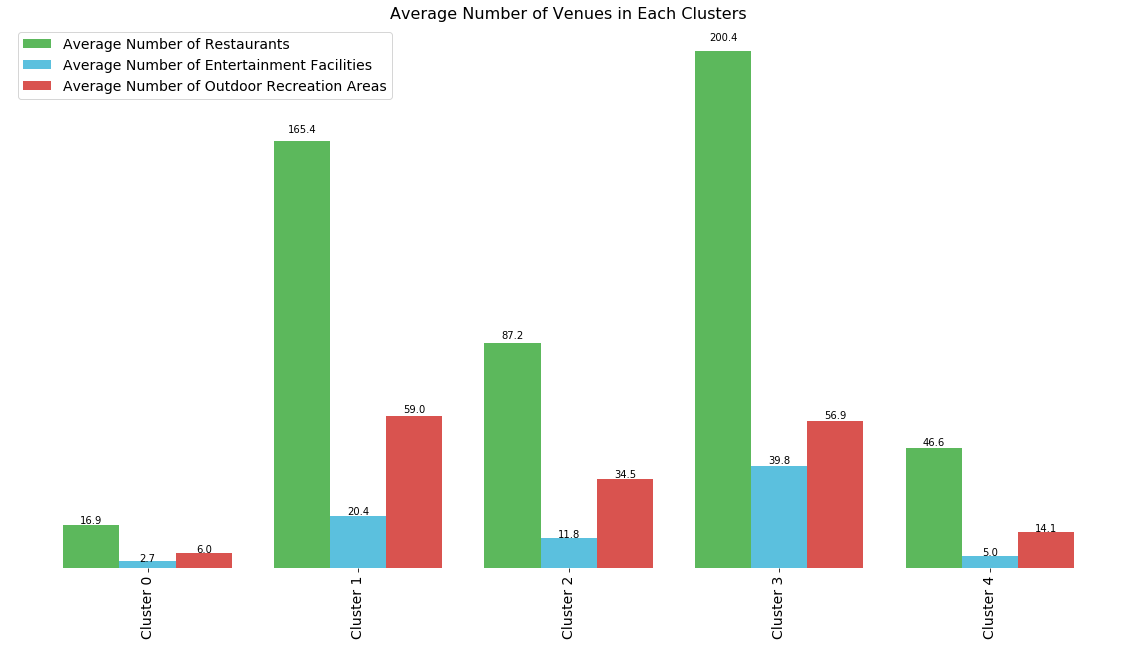

In [151]:
ax=plot.plot(kind='bar', figsize=(20,10), width=0.8, color=['#5cb85c','#5bc0de','#d9534f'])

plt.title('Average Number of Venues in Each Clusters',fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([])
for spine in plt.gca().spines.values():
    spine.set_visible(False)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.1f}', (x + width/2, y + height*1.02), ha='center')

plt.show()